In [1]:
import thinkplot
import thinkstats2
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy.stats as ss
import math
import random

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,8)

In [2]:
#Calculate RMSE from residuals
def rmseFromResiduals(residuals):
    SSE = 0
    for i in range(len(residuals)):
        SSE += (residuals[i]**2)
    MSE = SSE/len(residuals)
    return math.sqrt(MSE)
def rSquared(yvals, residuals):
    return (1-(thinkstats2.Var(residuals)/thinkstats2.Var(yvals)))

<h1>RMSE and R2 - A Second Look</h1>

Previously we calculated the RMSE, our measure of how much we can expect each prediction to be off by. However, the purpose of doing these predictions isn't to analyze the data we already have, it is to make predictions for new data. So when we are faced with brand new, never seen before data, how confident should we be in the accuracy of our models?

When we just calculated the RMSE, we calculated the residuals for the data we used to create the model. We should kind of expect that the model we end up with would be pretty good at making predictions of the data that was used to create it!

In order to get a more durable metric of error, we really need to test our model with some new data that it hasn't seen before. This will give us a better estimate of what type of accuracy we should expect when we put our model to use making real predictions.

How? We will hold out some data when we make the model, then use that saved data as though it were new. Since we know the real answers, we can calculate our error metrics and compare them to the true answers. 

So, new process:
<ul>
<li>Split our data into two parts. 
<li>Use one part to calculate a linear regression. (Train the model)
<li>Use the other part as a test - make predictions using the X values.
<li>Compare those predictions to the true Y values from the held-out data, use these residuals for accuracy. 
</ul>

In [3]:
#Load Data
df = pd.read_csv("data/brain.csv")
df = df.rename(columns={"Head Size(cm^3)":"X", "Brain Weight(grams)":"Y"})
x = "X"
y = "Y"
df.head()

,Gender,Age Range,X,Y
0,1,1,4512,1530
1,1,1,3738,1297
2,1,1,4261,1335
3,1,1,3777,1282
4,1,1,4177,1590


Plot to take a look:

<AxesSubplot:xlabel='X', ylabel='Y'>

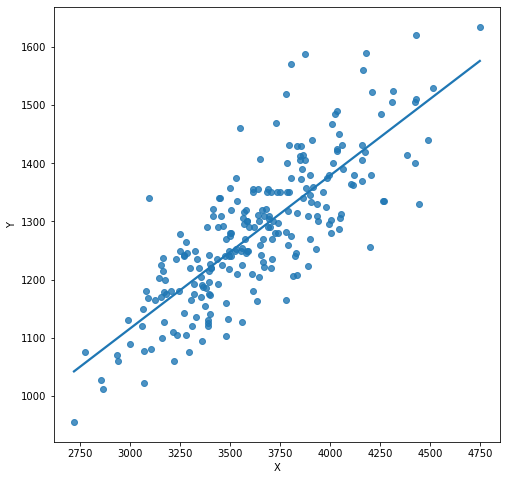

In [4]:
sns.regplot(data=df, x=x, y=y, ci=0)

Do the regression and calculate the original RMSE and R2

In [5]:
#Regression
inter, slope = thinkstats2.LeastSquares(df[x],df[y])
res = thinkstats2.Residuals(df[x], df[y], inter, slope)
regLine = thinkstats2.FitLine(df[x], inter, slope)
print("Y intercept:", inter)
print("Slope:", slope)
#RMSE/R2
print("RMSE", rmseFromResiduals(res))
print("R2", rSquared(df[y], res))

Y intercept: 325.5734210494426
Slope: 0.26342933948939934
RMSE 72.1206213783709
R2 0.639311719957


<h3>We have results, but are they good?</h3>

These are our measures of error. However, we're caclulating our model's error based on the data that it 'learned' from. It is kind of like predicting test performance by just giving someone a test to study, then giving it to them again to write. Not really all that portable. 

A better aproach is to test the predictions from our regression on brand new data, that we didn't use to train it. In other words, we can take one sample of our data to train our model, and another to test it. 

We will use 70% of the data to train the model, and the remaining 30% to test it. This is a pretty common split. In general, the more data you have, the smaller the percentage you need to test with. Somewhere around two-thirds training and one-third testing is a good starting point in most situations. 

We can try....

In [6]:
#Split the data into two. 

#Calculate the number of rows for the split
totalRows = len(df)
splitRatio = .7
trainRows = round(totalRows*splitRatio)
testRows = totalRows-trainRows

#Create split using sample(), which is random
train = df.sample(trainRows, replace=False)
test = df.drop(train.index)

#Results
print("Original Length:", len(df))
print("Train Length:", len(train))
print("Test Length:", len(test))

Original Length: 237
Train Length: 166
Test Length: 71


Now we have two separate datasets - we can make a regression with one set, then test it on the other set!

The model creation part is the same, except we are using the training subset, not the entirety of the data

In [7]:
#Regression
interTr, slopeTr = thinkstats2.LeastSquares(train[x],train[y])
print("Y intercept:", interTr)
print("Slope:", slopeTr)

Y intercept: 299.2013946683418
Slope: 0.26996373020510245


Note the results are somewhat different than the original - that is because we are only using some of the data to generate the regression model. If we rerun that splitting step before, each one will be a little different because the data that we use changes. How much this variation is depends on the dispersion of the data and the total amount of data - more data, more stable values. 

The testing/error calculation step is different. Now instead of evaluating the accuracy against the original data we used, we want to take our new leftover X values in the testing dataset, generate predictions for their Y values, and compare those predictions to the real Y values. 

In [8]:
#Calculate how far the held our data points are from the predictions to generate residuals
resTest = thinkstats2.Residuals(test[x], test[y], interTr, slopeTr)
#RMSE/R2
print("RMSE", rmseFromResiduals(resTest))
print("R2", rSquared(test[y], resTest))

RMSE 81.18694521914213
R2 0.6302081197522122


<h3>Updated Error Metrics</h3>

These results for RMSE and R2 are generated by actually testing the model, with data that is new to it. This is much more realistic to actual, real life use. If we are actually predicting brain size, we are going to be measuring a stream of new skulls, taking that value, and plugging it in to our regression to get a predicted brain size. That's exactly what we did here, but we have those real brain sizes that we can pull out after to calculate the accuracy. 

<br><br><br>
<h2>Repeated Trials</h2>

What if we were to repeat this a entire process few times? And tally up the results? 

We'll also add in proper documentation to this function, since we're fancy.

In [9]:
#Multiple samples and regressions.

def repeatedRegression(data, trials=1000, trainSplit=.7, xColName="X", yColName="Y"):
    """Perform multiple linear regressions and accumulate the results in lists.

    data: DataFrame of data
    trials: number of test runs to perform
    trainSplit: the percentage of data to use for model creation, the rest is held for testing. 
    xColName: the column name of the X data in the dataframe "data". 
    yColName: the column name of the X data in the dataframe "data".

    returns: intercepts, slopes, rmses, r2s
    """
    #Store each result in these lists. 
    intercepts = []
    slopes = []
    rmses = []
    r2s = []

    #Calculate the split size metrics
    totalRows = len(data)
    trainRows = round(totalRows*trainSplit)
    testRows = totalRows-trainRows

    for i in range(trials):
        #Randomly split the data
        train = data.sample(trainRows, replace=False)
        test = data.drop(train.index)
        #Do a Regression
        inter, slope = thinkstats2.LeastSquares(train[xColName],train[yColName])
        #print("Y intercept:", inter, "Slope:", slope)
        #Generate Residuals
        res = thinkstats2.Residuals(test[xColName], test[yColName], inter, slope)
        #RMSE/R2
        rmse = rmseFromResiduals(res)
        r2 = rSquared(test[yColName], res)
        #print("RMSE", rmse, "R2", r2)
        #Add all the results to the lists 
        intercepts.append(inter)
        slopes.append(slope)
        rmses.append(rmse)
        r2s.append(r2)
        
    return intercepts, slopes, rmses, r2s

In [10]:
#Run it for our data. 
intercepts, slopes, rmses, r2s = repeatedRegression(df,10000)
np.mean(intercepts), np.mean(slopes), np.mean(rmses), np.mean(r2s)

(325.8953389465443, 0.2633461009038939, 72.65866908214664, 0.630163674091794)

Similar to any of the estimation trials that we previously looked at, we just do the predicting over and over, and count up the results. 

We can plot all of these results to take a look. 

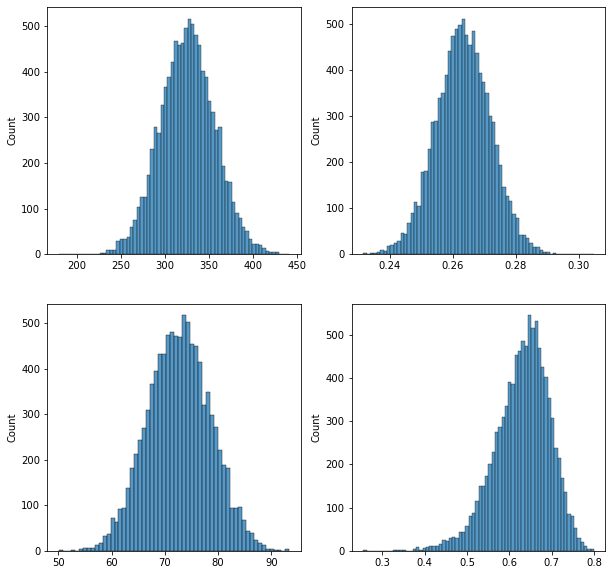

In [11]:
#Plot each set of results
thinkplot.PrePlot(2,2,2)
sns.histplot(intercepts)
thinkplot.SubPlot(2)
sns.histplot(slopes)
thinkplot.SubPlot(3)
sns.histplot(rmses)
thinkplot.SubPlot(4)
sns.histplot(r2s)
thinkplot.Config()

<h3>Repetitive Results</h3>

We end up with a distribution of results for each of our metrics. Like before, these distributions are descriptions of how likely the statistic is to fall at certain values. So we can do things like plot them in a CDF to look for confidence intervals. We can also analyze them to make sense of the regression - the less dispersed these values are, the more reliable our regression is likely to be - we get fewer changes depending on what subset of data we select. 

This particular dataset is pretty small, so we see some pretty large variation between trials. If we were to only do one split, we might randomly end up with one of the ones that had an RMSE or R2 way on the fringes of what is possible, and we'd not get an accurate assessment of our model's predictive quality. As the amount of data increases, this variation lessens. 

We can use the function from chapter 10 of the book to plot confidence intervals. 

In [12]:
#Book stuff to plot. 
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys
    
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

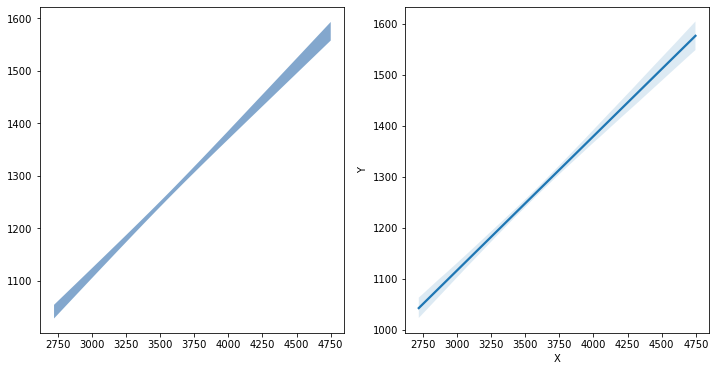

In [13]:
#Call PCI with our data. Graph alongside SNS
#These should be close, but they may differ slightly. The regplot does its own regression, so it may randomly vary. 
thinkplot.PrePlot(2,1,2)
PlotConfidenceIntervals(df[x], intercepts, slopes)
thinkplot.SubPlot(2)
sns.regplot(x=df[x], y=df[y], ci=90, scatter=False)
thinkplot.Config()

<h1>Weighted Resampling</h1>

Up until now, we've treated every row of data equally, however, in certain situations, that may not give us what we need. As an example, think about detecting fraud in a credit card transaction. A credit card company has a massive amount of data that they can (and do) use to train machine learning algorithms to look for fraudulent transactions. 

However, almost all of that data will NOT be fraudulent. There are millions and millions of legitimate transactions and while fraud isn't really rare, it does only happen in a small minority of cases. The problem this can cause when building models is that we might just not have enough examples of the rare thing (fraud) for our algorithm to accurately learn from. A similar thing can happen with medical data - if there are conditions that impact specific subsets of society differently (e.g. sickle cell is more common in black people, people from Northern Europe are more likely to tolerate lactose) then we might not have enough of those examples to generate reliable predictions, especially when sample sizes are limited by cost and when we are slicing our data into segments to build the algorithms. 

There are a few ways that we can attempt to deal with this, the simplest being to weight the samples - or pull more results from some subsets of data than others. For example, we can purposefully take a greater share of the fraudulent transactions to ensure that we have enough. In a medical example you'd make sure that there was a significant number of each subgroup in the data, to ensure that they aren't 'missed'.

<b>But wait, doesn't this mess up everything?</b>

In some ways yes, in others no. We aren't using the data here to look at the distribution or similar - the number of frauds/not frauds in the data isn't really something we care about. We are attempting to learn how to predict the outcome (fraud/not) given the input(s) - so we need to ensure that there's enough examples so that we can do so. If fraud makes up .1% of the data, or 50% of the data, that doesn't really impact what we're doing negatively. 

The only real metric for success is our accuracy in making those predictions, so if we need to distort data to get better predictions, that's fine. 

<b>This makes more sense in multiple regression, so we'll save it for then</b>